In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats
import cvxopt
import domain_adapt.domain_adapt.new.kmm as kmm
import domain_adapt.domain_adapt.new.utils as utils

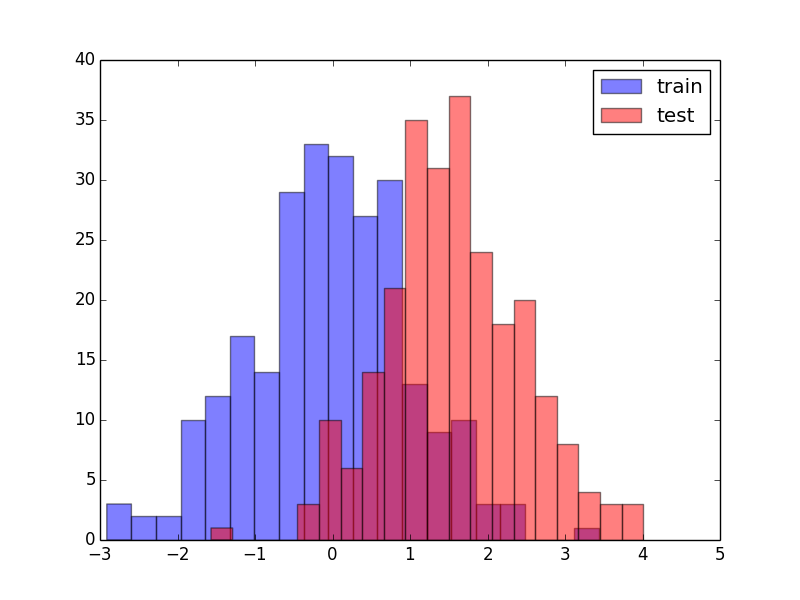

In [71]:
## define data ##

np.random.seed(40)

# define dimensionality of distributions
d = 1

# define train distribution
train_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=d))
train_pdf = train_dist.pdf
train_sample = train_dist.rvs

# define test distribution
test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=d)+1.5)
test_pdf = test_dist.pdf
test_sample = test_dist.rvs

# define number of samples to generate
num_train = 250
num_test = 250

# generate the samples
train_xs = np.array([train_sample() for i in xrange(num_train)])
test_xs = np.array([test_sample() for i in xrange(num_test)])
train_xs = train_xs.reshape((num_train,d))
test_xs = test_xs.reshape((num_test,d))

fig, ax = plt.subplots()
ax.hist(train_xs[:,0], color='b', label='train',bins=20,alpha=0.5)
ax.hist(test_xs[:,0], color='r', label='test',bins=20,alpha=0.5)
ax.legend()
basic.display_fig_inline(fig)

# define kernel function
def rbf(sigma, u, v):
    return np.exp(-(np.linalg.norm(u-v)**2) / (2*(sigma**2)))

#sigma = utils.median_distance(np.vstack((train_xs, test_xs)), np.vstack((train_xs, test_xs)))
#print 'sigma', sigma
sigma = 2.5
kernel_f = functools.partial(rbf, sigma)

# generate kernel matrices
K_train_train = utils.get_gaussian_K(sigma, train_xs, train_xs)
K_train_test = utils.get_gaussian_K(sigma, train_xs, test_xs)

In [72]:
## run kmm ##
B_max = 100
eps = .0001
ws = kmm.get_cvxopt_KMM_ws(B_max, eps, K_train_train, K_train_test)

     pcost       dcost       gap    pres   dres
 0: -2.7346e+04 -1.1235e+05  1e+06  5e-01  5e-16
 1: -2.7259e+04 -5.4225e+04  4e+04  7e-03  7e-15
 2: -2.7118e+04 -3.5328e+04  9e+03  2e-03  1e-14
 3: -2.7686e+04 -3.0796e+04  3e+03  2e-05  1e-13
 4: -2.7932e+04 -2.8575e+04  6e+02  2e-16  2e-12
 5: -2.7957e+04 -2.8012e+04  5e+01  2e-16  2e-13
 6: -2.7961e+04 -2.7968e+04  7e+00  2e-16  1e-14
 7: -2.7961e+04 -2.7962e+04  1e+00  2e-16  1e-15
 8: -2.7961e+04 -2.7962e+04  6e-02  2e-16  5e-16
 9: -2.7961e+04 -2.7961e+04  6e-03  2e-16  4e-16
Optimal solution found.


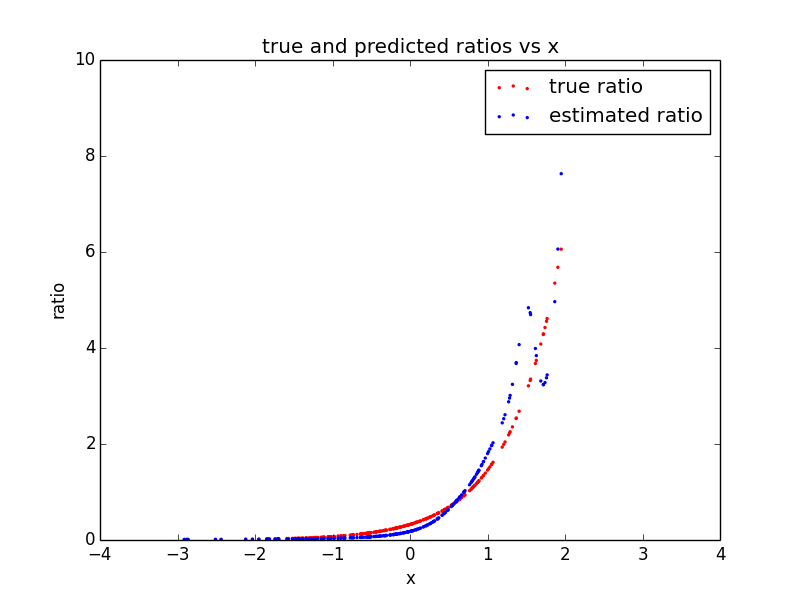

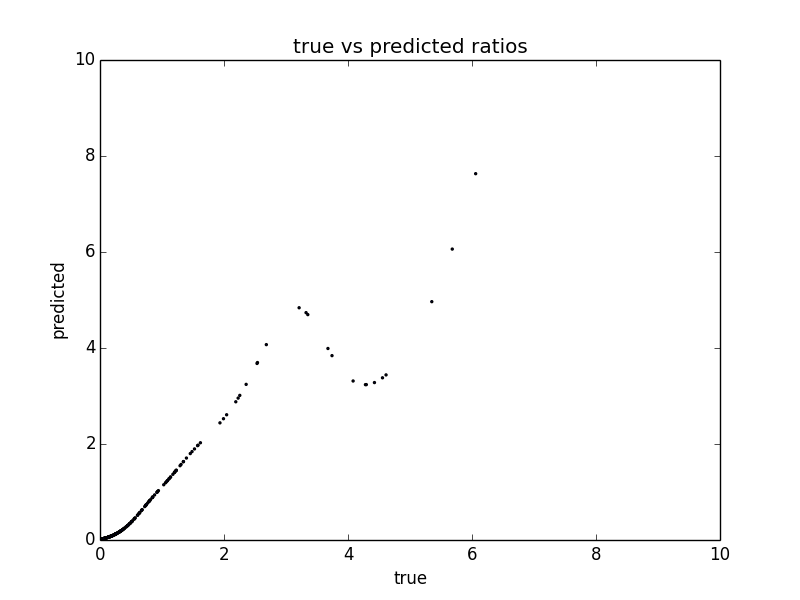

In [73]:
## check results ##

# calculate true ws
true_ws = test_pdf(train_xs) / train_pdf(train_xs)

# define plot constants
s = 2
max_lim = 10

# plot true vs estimated weights
fig, ax = plt.subplots()
ax.scatter(train_xs, true_ws, s=s,color='red',label='true ratio')
ax.scatter(train_xs, ws, s=s, color='blue',label='estimated ratio')
#ax.set_xlim((-max_lim,max_lim/2))
ax.set_ylim((0,max_lim))
ax.set_xlabel('x')
ax.set_ylabel('ratio')
ax.set_title('true and predicted ratios vs x')
ax.legend()
basic.display_fig_inline(fig)

# plot scatterplot
fig, ax = plt.subplots()
ax.scatter(true_ws, ws, s=s)
ax.set_xlabel('true')
ax.set_ylabel('predicted')
ax.set_xlim((0,max_lim))
ax.set_ylim((0,max_lim))
ax.set_title('true vs predicted ratios')
basic.display_fig_inline(fig)